In [1]:
import matplotlib.pyplot as plt
from PIL import Image  # Import Image from PIL
import requests
import json
import io, zipfile

# Define the path where the fashion dataset is stored
FASHION_DATASET_HOME = '/home/jcaldeira/dressing_virtuel_data_collector/media/images/'
#image = '0c0bfbde088d5b2f94f10b47f5b6352c28cbc148.jpg'
image = '100_0519.JPG'
#image = '20150501_161427.jpg'
#image = '100_0532.JPG'

# API endpoint to send requests
ENDPOINT = 'http://127.0.0.1:5000/dressing_virtuel'
DB_API = '627b040b9b048607b971ddc5f9ec854c5360dddda3c01e5a42d70c2be9d6a733'

ENDPOINT_CAT = 'http://127.0.0.1:5001/categorization_model'
CAT_API = '1a78d334b22900696ee93268e872a6ae438e881d390bb5c742c75d28ca0807bd'

ENDPOINT_SEG = 'http://127.0.0.1:5002/segmentation_model'
SEG_API = '5fa6b246d702d3cc70705430e49a8f53f4d7dce9f69506b00d20ff4121e946e3'

ENDPOINT_OBJ = 'http://127.0.0.1:5003/object_detection_model'
SEG_OBJ = 'c81bdbcf65b26b3be5b78417e7c65f4458e27d4a15315e19ee014774905530e6'

ENDPOINT_FACE = 'http://127.0.0.1:5004/face_recognition'
SEG_FACE = '2731e94da8ecad92d476121f0e168b6af4397dea35fb42e79eece60e126cf34d'

def get_categories(method, key):
    """
    Fetches categories (like gender, color, season, etc.) from the API.

    Args:
        method (str): API method to fetch (e.g., 'genders', 'colors').
        key (str): The key to extract from the API response (e.g., 'name', 'id').

    Returns:
        dict: A dictionary with category names as keys and their 
        corresponding IDs as values.
    """
    header = {"access_token":DB_API}
    response = requests.get(f"{ENDPOINT}/{method}",headers=header)
    dict = {x[key]: x['id'] for x in response.json()}

    return dict

def clip_evaluation_dict(subcategories, image_path):
    categories = {'categories_dict': json.dumps(subcategories)}
    header = {"access_token": CAT_API }

    files = {"image": ('100_0519.JPG', image_path, "image/jpeg")}

    response = requests.post(f"{ENDPOINT_CAT}/fit_categories",
                        files=files,
                        data=categories,
                        headers=header)
    
    return response.json()

def seg_evaluation(image_path):
    header = {"access_token":SEG_API }

    # Open the image file in binary mode
    with open(image_path, "rb") as image_file:
        # Create the payload with the file
        files = {"image": (image_path, image_file, "image/jpeg")}
        
        response = requests.post(f"{ENDPOINT_SEG}/crop_single_clothes",
                            files=files,
                            headers=header)

    return response

def seg_fullbody_evaluation(image_path):
    header = {"access_token":SEG_API }
    
    # Open the image file in binary mode
    with open(image_path, "rb") as image_file:
        # Create the payload with the file
        files = {"image": (image_path, image_file, "image/jpeg")}
        
        response = requests.post(f"{ENDPOINT_SEG}/crop_fullbody_clothes",
                                files=files,
                                headers=header)

    return response

def person_detection(image_path):
    header = {"access_token":SEG_OBJ }
    category_to_detect = {'category_to_detect':'person'}

        # Open the image file in binary mode
    with open(image_path, "rb") as image_file:
        # Create the payload with the file
        files = {"image": (image_path, image_file, "image/jpeg")}

        response = requests.post(f"{ENDPOINT_OBJ}/crop_detection",
                            files=files,
                            data=category_to_detect,
                            headers=header)
    
    return response

def face_detection(image_path, zip_file):
    header = {"access_token":SEG_FACE }

    with open(image_path, "rb") as image_file:
            files = {"image": (image_path, image_file, "image/jpeg"),
                    "images_to_search" : ('archive.zip', zip_file , "application/x-zip-compressed")}

            response = requests.post(f"{ENDPOINT_FACE}/face_detection",
                                files=files,
                                headers=header)
    
    return response


In [2]:
import torch
x = torch.rand(1).cuda()
print(x)
print(torch.__version__)
print(torch.version.cuda)

tensor([0.6905], device='cuda:0')
2.4.1+cu121
12.1


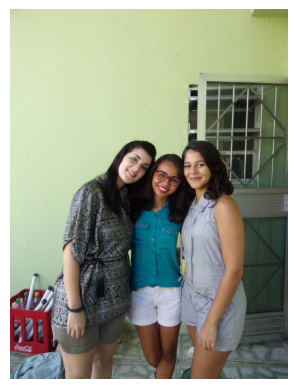

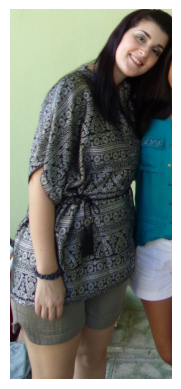

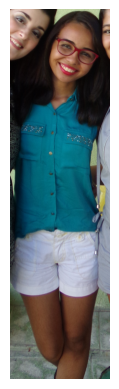

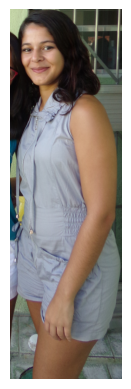

In [3]:
test = Image.open(FASHION_DATASET_HOME +'/'+ image)
plt.imshow(test)
plt.axis('off')  # Turn off the axis
plt.show()

person_response = person_detection(FASHION_DATASET_HOME +'/'+ image)

# Check if the response is OK
if person_response.ok:

    # Read the ZIP archive from the response content
    zip_file = zipfile.ZipFile(io.BytesIO(person_response.content))
    
    # Extract and display each image
    for file_name in zip_file.namelist():
        # Open the image from the ZIP file
        with zip_file.open(file_name) as image_file:
            image = Image.open(image_file)
            plt.imshow(image)
            plt.axis('off')  # Turn off the axis
            plt.show()



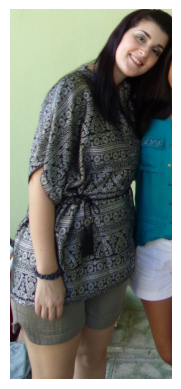

In [5]:
face_response = face_detection(FASHION_DATASET_HOME +'/brii/brii.jpg' , 
                               io.BytesIO(person_response.content))

if face_response.ok:
    image = Image.open(io.BytesIO(face_response.content))
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.show()
    image.save(FASHION_DATASET_HOME + "/face_detection/teste.jpg")

In [6]:
# Fetch categories from the API and store them in dictionaries
print('Getting Categories from Database ...')
dict_genders = get_categories('genders','gender')
dict_seasons = get_categories('seasons','name')
dict_colors = get_categories('colors','name')
dict_usage = get_categories('usage_types','name')
dict_article = get_categories('article_types','name')



Getting Categories from Database ...


In [7]:
# Loop through all images in the dataset
#image_path = FASHION_DATASET_HOME + '/' + image
image_path = FASHION_DATASET_HOME + "/face_detection/teste.jpg"

print('Executing the segmentation over the image...')
#response = seg_evaluation(image_path)
response = seg_fullbody_evaluation(image_path)



Executing the segmentation over the image...


Extracting the categories from the cropped image ...


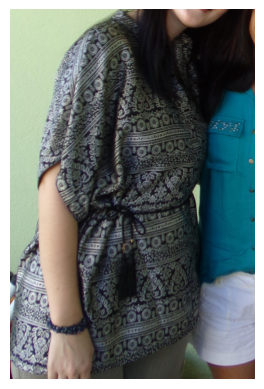

path: <zipfile.ZipExtFile name='image_1730148691_btg9ry.png' mode='r'>
{'gender': 'Unisex', 'season': 'Summer', 'color': 'Preto', 'usage': 'Ethnic', 'article': 'Shrug'}
Extracting the categories from the cropped image ...


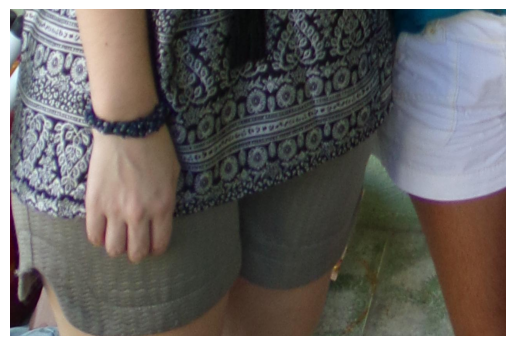

path: <zipfile.ZipExtFile name='image_1730148692_rnwiqw.png' mode='r'>
{'gender': 'Girls', 'season': 'Summer', 'color': 'Khaki', 'usage': 'Casual', 'article': 'Shorts'}


In [10]:
import io, zipfile
# Check if the response is OK
if response.ok:
    # Read the ZIP archive from the response content
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    
    # Extract and display each image
    for file_name in zip_file.namelist():
        # Open the image from the ZIP file
        with zip_file.open(file_name) as image_file:
            print('Extracting the categories from the cropped image ...')
            dict_of_categories = {
                'gender': list(dict_genders.keys()),
                'season': list(dict_seasons.keys()),
                'color': list(dict_colors.keys()),
                'usage': list(dict_usage.keys()),
                'article': list(dict_article.keys())
            }

            image = Image.open(image_file)
            plt.imshow(image)
            plt.axis('off')  # Turn off the axis
            plt.show()

            # Convert the image into an in-memory binary file
            img_byte_arr = io.BytesIO()  # Create a bytes buffer
            image.save(img_byte_arr, format='JPEG')  # Save the image in JPEG format in the buffer
            img_byte_arr.seek(0)  # Go back to the start of the BytesIO buffer

            # Perform CLIP evaluation to get the best matching category for each attribute
            selected_categories = clip_evaluation_dict(dict_of_categories,img_byte_arr)


            print(f"path: {image_file}")
            print(selected_categories)